# Data sets and models

In [ ]:
#| default_exp models

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *


In [ ]:
#| export

from enum import Enum, auto
from typing import Dict, List, Tuple

from pathlib import Path

import numpy as np
import polars as pl

## Model preprocessing

In [ ]:
#| export
from numpy.lib.stride_tricks import as_strided
from pisces.data_sets import DataSetObject

def psg_to_sleep_wake(psg: pl.DataFrame) -> np.array:
    # map all positive classes to 1 (sleep)
    # retain all 0 (wake) and -1 (mask) classes
    return np.where(psg[:, 1] > 0, 1, psg[:, 1])

def get_activity_X_PSG_y(data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
    activity_0 = data_set.get_feature_data("activity", id)
    psg_0 = data_set.get_feature_data("psg", id)

    if activity_0 is None or psg_0 is None:
        return None

    # trim the activity and psg data to both end when the 0th column (time) of either ends
    end_time = min(activity_0[-1, 0], psg_0[-1, 0])
    activity_0 = activity_0.filter(activity_0[:, 0] <= end_time)
    psg_0 = psg_0.filter(psg_0[:, 0] <= end_time)

    X = activity_0[:, 1].to_numpy()
    # make the reshape(-1, 2) non-ragged 
    # remove the last element if the length is odd
    if res := X.shape[0] % 2:
        #! X[:-0] is empty, so don't do this if res == 0
        X = X[:-res] 
    X = X.reshape((-1, 2)).sum(axis=1)
    y = psg_to_sleep_wake(psg_0)

    return X, y

def rolling_window(arr, window_size):
    strided_axis_0 = max(arr.shape[0] - window_size + 1, 0)
    arr_strided = as_strided(arr, shape=(strided_axis_0, window_size), strides=(arr.strides[0], arr.strides[0]))
    return arr_strided

In [ ]:
#| test
input_vec = np.arange(10)
expected_rolling = np.array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])
rolled = rolling_window(input_vec, 3)


assert np.array_equal(rolled, expected_rolling), f"Expected {expected_rolling}, but got {rolled}"

In [ ]:
#| export

import polars as pl
import numpy as np
from scipy.ndimage import gaussian_filter1d

def apply_gausian_filter(df: pl.DataFrame, sigma: float = 1.0, overwrite: bool = False) -> pl.DataFrame:
    data_columns = df.columns[1:]  # Adjust this to match your data column indices

    # Specify the standard deviation of the Gaussian kernel
    sigma = 1.0  # This controls the smoothing. Adjust based on your data's sampling rate and desired smoothing

    # Apply Gaussian smoothing to each data column
    for col in data_columns:
        new_col_name = f"{col}_smoothed" if not overwrite else col
        df = df.with_columns(
            pl.Series(gaussian_filter1d(df[col].to_numpy(), sigma)).alias(new_col_name)
        )
    return df

def fill_gaps_in_accelerometer_data(acc: pl.DataFrame, smooth: bool = False, final_sampling_rate_hz: int | None = None) -> np.ndarray:
    
    # median sampling rate (to account for missing data)
    sampling_period_s = acc[acc.columns[0]].diff().median() # 1 / sampling_rate_hz
    
    # Step 0: Save the original 'timestamp' column as 'timestamp_raw'
    acc_resampled = acc.with_columns(acc[acc.columns[0]].alias('timestamp'))

    if isinstance(final_sampling_rate_hz, int):
        final_rate_sec = 1 / final_sampling_rate_hz
        print(f"resampling to {final_sampling_rate_hz}Hz ({final_rate_sec:0.5f}s) from {int(1/sampling_period_s)} Hz ({sampling_period_s:0.5f}s)")
        # make a new data frame with the new timestamps
        # do this using linear interpolation

        median_time = acc_resampled['timestamp'].to_numpy()
        final_timestamps = np.arange(median_time.min(), median_time.max() + final_rate_sec, final_rate_sec)
        median_data = acc_resampled[:, 1:4].to_numpy()
        new_data = np.zeros((final_timestamps.shape[0], median_data.shape[1]))
        for i in range(median_data.shape[1]):
            new_data[:, i] = np.interp(final_timestamps, median_time, median_data[:, i])
        acc_resampled = pl.DataFrame({
            'timestamp': final_timestamps, 
            **{
                acc_resampled.columns[i+1]: new_data[:, i] 
                for i in range(new_data.shape[1])
            }})


    if smooth:
        acc_resampled = apply_gausian_filter(acc_resampled, overwrite=True)

    return acc_resampled


resampling to 50Hz (0.02000s) from 50 Hz (0.02000s)


<matplotlib.legend.Legend>

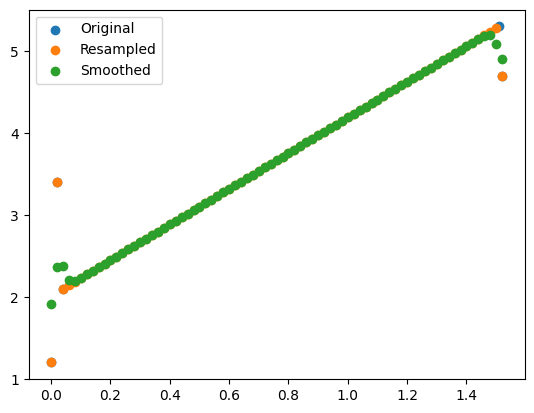

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'acc' is your existing Polars DataFrame with the first column as 'timestamp'.
acc = pl.DataFrame({
    "timestamp": [0, 0.02, 0.04, 1.51, 1.52],  # Irregular timestamps
    "sensor1": [1.2, 3.4, 2.1, 5.3, 4.7],
    "sensor2": [0.5, 0.8, 1.1, 0.3, 1.9]
})

acc_resampled = fill_gaps_in_accelerometer_data(acc, final_sampling_rate_hz=50)
acc_resampled = apply_gausian_filter(acc_resampled, overwrite=False)

# Plot the original and resampled timestamps
plt.scatter(acc['timestamp'], acc['sensor1'], label='Original')
plt.scatter(acc_resampled['timestamp'], acc_resampled['sensor1'], label='Resampled')
plt.scatter(acc_resampled['timestamp'], acc_resampled['sensor1_smoothed'], label='Smoothed')
plt.legend()

In [ ]:
acc_resampled

timestamp,sensor1,sensor2,sensor1_smoothed,sensor2_smoothed
f64,f64,f64,f64,f64
0.0,1.2,0.5,1.908138,0.62661
0.02,3.4,0.8,2.360776,0.800721
0.04,2.1,1.1,2.377994,0.988355
0.06,2.143537,1.089116,2.212371,1.06949
0.08,2.187075,1.078231,2.19292,1.07677
…,…,…,…,…
1.44,5.147619,0.338095,5.147536,0.33831
1.46,5.191156,0.327211,5.188312,0.334542
1.48,5.234694,0.316327,5.198158,0.410174


In [ ]:
# make a Gaussian-distributed random vector with 1000 elements
# mean zero, stdev 0.001

normal_vec = np.abs(np.random.normal(0.02, 0.001, 1000))
times = np.cumsum(normal_vec)

In [ ]:
y = np.random.normal(0, 1, len(normal_vec))

In [ ]:
df = pl.DataFrame({
    "timestamp": times,
    "y": y,
    "cos_y": np.cos(times),
})

In [ ]:
df_r = fill_gaps_in_accelerometer_data(df, smooth=False, final_sampling_rate_hz=50)

resampling to 50Hz (0.02000s) from 50 Hz (0.01991s)


<matplotlib.legend.Legend>

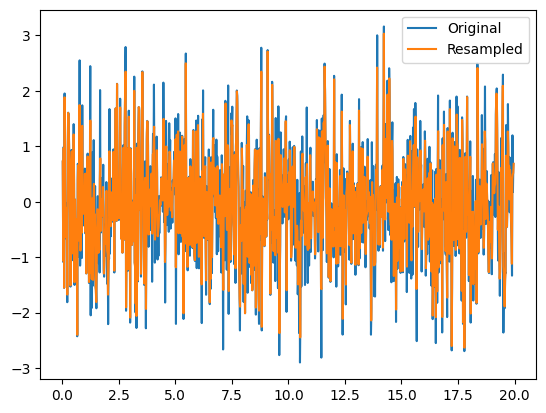

In [ ]:
plt.plot(df['timestamp'], df['y'], label='Original')
plt.plot(df_r['timestamp'], df_r['y'], label='Resampled')
plt.legend()

[<matplotlib.lines.Line2D>]

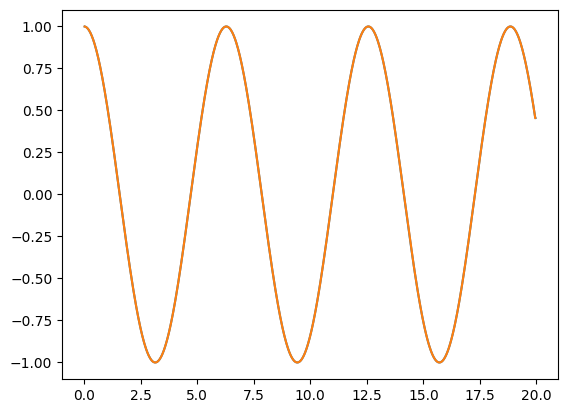

In [ ]:
plt.plot(df_r['timestamp'], df_r['cos_y'], label='Resampled')
plt.plot(df['timestamp'], df['cos_y'], label='Original')

## Classifier models

In [ ]:
#| export
import abc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
import numpy as np


class SleepWakeClassifier(abc.ABC):
    """
    """
    @abc.abstractmethod
    def get_needed_X_y(self, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        pass
    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        pass
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        pass
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        pass


### SGD Logistic Regression

In [ ]:
#| export

class SGDLogisticRegression(SleepWakeClassifier):
    """Uses Sk-Learn's `SGDCLassifier` to train a logistic regression model. The SGD aspect allows for online learning, or custom training regimes through the `partial_fit` method.
     
    The model is trained with a balanced class weight, and uses L1 regularization. The input data is scaled with a `StandardScaler` before being passed to the model.
    """
    def __init__(self, lr: float = 0.15, input_dim: int = 11, output_dim: int = 1):
        self.model = SGDClassifier(loss='log_loss',
                                   learning_rate='adaptive',
                                   penalty='l1',
                                   eta0=lr,
                                   class_weight='balanced',
                                   warm_start=True)
        self.scaler = StandardScaler()
        self.pipeline = make_pipeline(self.scaler, self.model)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.window_step = 1

    def get_needed_X_y(self, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        return get_activity_X_PSG_y(data_set, id)
    
    def _prepare_labels(self, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        y_trimmed = self._trim_labels(y)
        n_sleep = np.sum(y_trimmed > 0)
        n_wake = np.sum(y_trimmed == 0)
        N = n_sleep + n_wake
        # Want to make a balanced weight loss, along with giving 0.0 * loss for masked values (y < 0)
        mask_weights_zero = np.where(y_trimmed < 0, 0.0, 1)
        # balancing_weights_ignore_mask = np.where(y_trimmed > 0, n_wake / N, n_sleep / N)
        balancing_weights_ignore_mask = np.where(y_trimmed > 0, N / n_sleep, N / n_wake)
        sample_weights = mask_weights_zero * balancing_weights_ignore_mask

        y_demasked = np.where(y_trimmed < 0, 0, y_trimmed)

        return y_demasked, sample_weights

    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        if examples_X or examples_y:
            assert len(examples_X) == len(examples_y)
        if pairs_Xy:
            assert not examples_X
        
        training = []
        training_iterator = iter(pairs_Xy) if pairs_Xy else zip(examples_X, examples_y)
        for X, y in training_iterator:
            try:
                X_folded = self._fold(X)
                y_prepped, sample_weights = self._prepare_labels(y)
                if (X_folded.shape[0] != y_prepped.shape[0]) \
                    or (X_folded.shape[0] == 0) \
                    or (y_prepped.shape[0] == 0):
                    continue
                training.append((X_folded, y_prepped, sample_weights))
            except Exception as e:
                print(f"Error folding or trimming data: {e}")
                continue
        
        Xs = [X for X, _, _ in training]
        ys = [y for _, y, _ in training]
        weights = [w for _, _, w in training]
        Xs = np.concatenate(Xs, axis=0)
        ys = np.concatenate(ys, axis=0)
        weights = np.concatenate(weights, axis=0)

        selector = ys >= 0
        Xs = Xs[selector]
        ys = ys[selector]
        weights = weights[selector]

        self.pipeline.fit(Xs, ys)
    
    def _input_preprocessing(self, X: np.ndarray) -> np.ndarray:
        return self.scaler.transform(self._fold(X))
    
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict(self._input_preprocessing(sample_X))
    
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict_proba(self._input_preprocessing(sample_X))
    
    def _fold(self, input_X: np.ndarray | pl.DataFrame) -> np.array:
        if isinstance(input_X, pl.DataFrame):
            input_X = input_X.to_numpy()
        return rolling_window(input_X, self.input_dim)
    
    def _trim_labels(self, labels_y: pl.DataFrame) -> np.ndarray:
        start, end = self._indices_to_trim()
        # return labels_y[self.input_dim:]
        return labels_y[start:-end]
        
    def _indices_to_trim(self) -> Tuple[int, int]:
        # ex: input_dim = 8 => (4, 3)
        # ex: input_dim = 7 => (3, 3)
        # ex: input_dim = 6 => (3, 2)
        return (self.input_dim // 2, self.input_dim - (self.input_dim // 2))

### Mads Olsen et all classifier

We have downloaded the saved model weights from a [research repository from Mads Olsen's group](https://github.com/MADSOLSEN/SleepStagePrediction), and converted those into a saved Keras model to remove the need to re-define all of the layers. This conversion process is shown in `../analyses/convert_mads_olsen_model_to_keras.ipynb`.

Thus, we have a TensorFlow model that we can run inference on, and we could train it if we wanted to.

For simplicity, we are just going to run inference. One twist of our method is that the classifier is expecting two high-resolution spectrograms for inputs:
1. 3-axis Accelerometer data
2. PPG (photoplethysmogram) data

Based on visually inspecting examples from the paper, we are going to hack together an input by flipping the accelerometer data along the frequencies axis. The paper images seem to show a similarity between high-frequency accelerometer data and low-frequency PPG data. Surprisingly, this seems to work well.

In [ ]:
#| export


from functools import partial
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import warnings

from pisces.mads_olsen_support import *
from pisces.utils import split_analysis


class MOResUNetPretrained(SleepWakeClassifier):
    tf_model = load_saved_keras()
    config = MO_PREPROCESSING_CONFIG

    def __init__(
        self,
        sampling_hz: int = FS,
    ) -> None:
        """
        Initialize the MOResUNetPretrained classifier.

        Args:
            sampling_hz (int, optional): The sampling frequency in Hz. Defaults to FS.
        """
        super().__init__()
        self.sampling_hz = sampling_hz

    def prepare_set_for_training(self, 
                                 data_set: DataSetObject, ids: List[str] | None = None,
                                 max_workers: int | None = None 
                                 ) -> List[Tuple[np.ndarray, np.ndarray] | None]:
        """
        Prepare the data set for training.

        Args:
            data_set (DataSetObject): The data set to prepare for training.
            ids (List[str], optional): The IDs to prepare. Defaults to None.
            max_workers (int, optional): The number of workers to use for parallel processing. Defaults to None, which uses all available cores. Setting to a negative number leaves that many cores unused. For example, if my machine has 4 cores and I set max_workers to -1, then 3 = 4 - 1 cores will be used; if max_workers=-3 then 1 = 4 - 3 cores are used.

        Returns:
            List[Tuple[np.ndarray, np.ndarray] | None]: A list of tuples, where each tuple is the result of `get_needed_X_y` for a given ID. An empty list indicates an error occurred during processing.
        """
        if ids is None:
            ids = data_set.ids
        results = []
        
        if ids:
            data_set_and_ids = [(data_set, id) for id in ids]
            # Get the number of available CPU cores
            num_cores = multiprocessing.cpu_count()
            workers_to_use = max_workers if max_workers is not None else num_cores
            if (workers_to_use > num_cores):
                warnings.warn(f"Attempting to use {max_workers} but only have {num_cores}. Running with {num_cores} workers.")
                workers_to_use = num_cores
            if workers_to_use <= 0:
                workers_to_use = num_cores + max_workers
            if workers_to_use < 1:
                # do this check second, NOT with elif, to verify we're still in a valid state
                raise ValueError(f"With `max_workers` == {max_workers}, we end up with max_workers + num_cores ({max_workers} + {num_cores}) which is less than 1. This is an error.")

            print(f"Using {workers_to_use} of {num_cores} cores ({int(100 * workers_to_use / num_cores)}%) for parallel preprocessing.")
            print(f"This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)")

            # Create a pool of workers
            with ProcessPoolExecutor(max_workers=workers_to_use) as executor:
                results = list(
                    executor.map(
                        self.get_needed_X_y_from_pair, 
                        data_set_and_ids
                    ))
        else:
            warnings.warn("No IDs found in the data set.")
            return results
        return results
    
    def get_needed_X_y_from_pair(self, pair: Tuple[DataSetObject, str]) -> Tuple[np.ndarray, np.ndarray] | None:
        """
        Get the needed X and y data from a pair of data set and ID.

        Args:
            pair (Tuple[DataSetObject, str]): The pair of data set and ID.

        Returns:
            Tuple[np.ndarray, np.ndarray] | None: The X and y data as a tuple, or None if an error occurred.
        """
        data_set, id = pair
        print(f"getting needed X, y for {id}")
        return self.get_needed_X_y(data_set, id)
    
    def get_needed_X_y(self, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        accelerometer = data_set.get_feature_data("accelerometer", id)
        psg = data_set.get_feature_data("psg", id)

        if accelerometer is None or psg is None:
            print(f"ID {id} {'psg' if psg is None else 'accelerometer'} not found in {data_set.name}")
            return None
        
        print("sampling hz:", self.sampling_hz)
        accelerometer = fill_gaps_in_accelerometer_data(accelerometer, smooth=False, final_sampling_rate_hz=self.sampling_hz)
        stop_time = min(accelerometer[:, 0].max(), psg[:, 0].max())
        accelerometer = accelerometer.filter(accelerometer[:, 0] <= stop_time)
        psg = psg.filter(psg[:, 0] <= stop_time)


        mirrored_spectro = self._input_preprocessing(accelerometer)

        return mirrored_spectro, psg_to_sleep_wake(psg)

    def train(self, 
              examples_X: List[pl.DataFrame] = [], 
              examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        """Training is not implemented yet for this model. You can run inference, though, using `predict_probabilities` and `predict`."""
        pass

    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return np.argmax(self.predict_probabilities(sample_X), axis=1)

    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        if isinstance(sample_X, pl.DataFrame):
            sample_X = sample_X.to_numpy()
        return self._evaluate_tf_model(sample_X)

    def roc_curve(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError
    def roc_auc(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> float:
        raise NotImplementedError

    @classmethod
    def _spectrogram_preprocessing(cls, acc_xyz: np.ndarray) -> np.ndarray:
        return cls._preprocessing(acc_xyz)

    @classmethod
    def _input_preprocessing(
        cls,
        acc_xyz: pl.DataFrame | np.ndarray
    ) -> np.ndarray:

        spec = cls._spectrogram_preprocessing(acc_xyz)

        # We will copy the spectrogram to both channels, flipping it on channel 1
        input_shape = (1, *MO_UNET_CONFIG['input_shape'])
        inputs_len = input_shape[1]

        inputs = np.zeros(shape=input_shape, dtype=np.float32)
        # We must do some careful work with indices to not overflow arrays
        spec = spec[:inputs_len].astype(np.float32) # protect agains spec.len > input_shape

        #! careful, order matters here. We first trim spec to make sure it'll fit into inputs,
        # then compute the new length which we KNOW is <= inputs_len
        spec_len = spec.shape[0]
        # THEN we assign only as much inputs as spec covers
        inputs[0, : spec_len, :, 0] = spec # protect agains spec_len < input_shape
        inputs[0, : spec_len, :, 1] = spec[:, ::-1]

        return inputs

    def _evaluate_tf_model(self, inputs: np.ndarray) -> np.ndarray:
        # set input tensor to FLOAT32
        inputs = inputs.astype(np.float32)

        # run inference
        preds = self.tf_model.predict(inputs)

        return preds
    
    @classmethod
    def _preprocessing(
        cls,
        acc: pl.DataFrame | np.ndarray
    ) -> np.ndarray:
        """
        The Mads Olsen repo uses a list of transformations
        """
        if isinstance(acc, pl.DataFrame):
            acc = acc.to_numpy()
        x_ = acc[:, 0]
        y_ = acc[:, 1]
        z_ = acc[:, 2]
        for step in cls.config["preprocessing"]:
            fn = eval(step["type"])  # convert string version to function in environment
            fn_args = partial(
                fn, **step["args"]
            )  # fill in the args given, which must be everything besides numerical input

            # apply
            x_ = fn_args(x_)
            y_ = fn_args(y_)
            z_ = fn_args(z_)

        spec = x_ + y_ + z_
        spec /= 3.0

        return spec

    def evaluate_data_set(self, data_set: DataSetObject, exclude: List[str] = [], max_workers: int = None) -> Tuple[Dict[str, dict], list]:
        filtered_ids = [id for id in data_set.ids if id not in exclude]
        mo_preprocessed_data = [
            (d, i) 
            for (d, i) in zip(
                self.prepare_set_for_training(data_set, filtered_ids, max_workers=max_workers),
                filtered_ids) 
            if d is not None
        ]

        evaluations: Dict[str, dict] = {}
        for i, ((X, y), id) in enumerate(mo_preprocessed_data):
            y_hat_proba = self.predict_probabilities(X)
            y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
            analysis = split_analysis(y, y_hat_sleep_proba)
            evaluations[id] = analysis
            print(f"Processing {i+1} of {len(mo_preprocessed_data)} ({id})... AUROC: {analysis['auc']}")
        return evaluations, mo_preprocessed_data



### Training tools

In [ ]:
#| export
from typing import Type
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut


class SplitMaker:
    def split(self, ids: List[str]) -> Tuple[List[int], List[int]]:
        raise NotImplementedError
    
class LeaveOneOutSplitter(SplitMaker):
    def split(self, ids: List[str]) -> Tuple[List[int], List[int]]:
        loo = LeaveOneOut()
        return loo.split(ids)

def run_split(train_indices, 
              preprocessed_data_set: List[Tuple[np.ndarray, np.ndarray]], 
              swc: SleepWakeClassifier) -> SleepWakeClassifier:
    training_pairs = [
        preprocessed_data_set[i][0]
        for i in train_indices
        if preprocessed_data_set[i][0] is not None
    ]
    swc.train(pairs_Xy=training_pairs)

    return swc

def run_splits(split_maker: SplitMaker, w: DataSetObject, swc_class: Type[SleepWakeClassifier], exclude: List[str] = []) -> Tuple[
        List[SleepWakeClassifier], 
        List[np.ndarray],
        List[List[List[int]]]]:
    split_models: List[swc_class] = []
    test_indices = []
    splits = []

    preprocessed_data = [(swc_class().get_needed_X_y(w, i), i) for i in w.ids if i not in exclude]

    for train_index, test_index in tqdm(split_maker.split(w.ids)):
        if preprocessed_data[test_index[0]][0] is None:
            continue
        model = run_split(train_indices=train_index,
                        preprocessed_data_set=preprocessed_data,
                        swc=swc_class())
        split_models.append(model)
        test_indices.append(test_index[0])
        splits.append([train_index, test_index])
        # break
    
    return split_models, preprocessed_data, splits



In [ ]:
#| hide
import nbdev
nbdev.nbdev_export()